## DATA SCIENCE BLOG POST ON HOME HEALTH STAR RATING 

## INTRODUCTION
This repository analyzes **state-level home health (HH) star ratings** and identifies key factors associated with higher **Quality of Patient Care Star Rating**, including a *what-if* scenario for flu shot compliance. The dataset is provided in `HH_State_Oct2025.csv` and the modeling code has been refactored into modular functions.

## 1. Business Understanding

**Goal:**
To understand which measurable quality metrics are most strongly associated with higher home health star ratings and simulate potential impact of targeted interventions. In this case, we look at *what-if* scenario of increasing flu shot compliance by +10%. The analysis leverages a RandomForest-based approach to rank feature importance and to run this prediction.

**Success Criteria:**
1. Identify top drivers of star ratings via model feature importance.
2. Achieve reasonable model evaluated by MSE and R² value based on 80/20 split training and test set, respectively.
3. Provide a ranked list of states where a +10% change in flu shot compliance yields the largest predicted improvement.

## 2. Data Understanding

**Source file:** 
In general, `HH_State_Oct2025.csv` file contains a list of US states in a column, and each row showing the target rating and multiple quality metrics for home health in each state.

**More info:**
This dataset used in this analysis is publicly available [here](https://data.cms.gov/provider-data/dataset/tee5-ixt5). It was published by Centers for Medicare & Medicaid Services (CMS) on October 22, 2025.

Below is the code to understand the data. Function named "summarize_and_plot" has been defined to load a CSV, print a data overview and plot histogram for numeric columns.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import textwrap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [22]:
# Data Loading

def load_data(filepath: str) -> pd.DataFrame:
    """Load CSV dataset into a pandas DataFrame."""
    df = pd.read_csv(filepath)
    print(f"Loaded dataset: {filepath}")
    print(f"Shape: {df.shape}")

    return df

In [7]:
# Data Exploration and Summary

def explore_data(df: pd.DataFrame):
    """Perform basic EDA: columns, datatypes, missing values, and summary stats."""
    print("\n--- Basic Exploration ---")
    print("Columns:\n", df.columns.tolist())
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())
    print("\nSummary Statistics:\n", df.describe())

In [14]:
# Build histograms for numeric columns

def plot_histograms(df: pd.DataFrame):
    """Plot histograms for numeric columns."""
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    axes = df[numeric_cols].hist(figsize=(17, 14), bins=15)

    for ax, col in zip(axes.ravel(), numeric_cols):
        wrapped_title = "\n".join(textwrap.wrap(col, width=40))
        ax.set_title(wrapped_title, fontsize=10)

    plt.suptitle("Histograms of Numeric Features", fontsize=16)
    plt.tight_layout()
    plt.show()

## 3. Data Preparation

1. There are columns that are non-numeric and contain '-' which are `Transfer of Health Information to the Provider` and `Transfer of Health Information to the Patient` indicating the data maybe non-applicable or unavailable. This columns are non-numeric and since we only select numeric columns for model, therefore it will not be an issue.
2. Target column will be `Quality of Patient Care Star Rating` and this data is numeric.
3. Potential leakage columns include those starting with `Star Rating` and containing `Percentage`.

## 4. Modeling

1. To build the model, `RandomForestRegressor` (scikit-learn) was chosen to train on standardized numeric features.
2. Model evaluation is based on **Mean Squared Error (MSE)** and **R²** on the test set.

In [15]:
# For modeling, we fixed the 20% test set and define the target as target_col, column with integer as numeric_cols, and leak_cols to avoid star rating columns to appear in the bar chart

def train_random_forest(df, target_col, test_size=0.2, random_state=42):
    print(f"\n--- Training Model (Target: {target_col}) ---")
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    leak_cols = [c for c in df.columns if c.startswith('Star Rating') and 'Percentage' in c]

    X = df[numeric_cols].drop(columns=[col for col in [target_col] + leak_cols if col in df.columns])
    y = df[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    ##Scale the value in the columns to be standard
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(random_state=random_state)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Model trained — MSE: {mse:.4f}, R²: {r2:.4f}")

    return model, scaler, X, y


## 5. Evaluation
1. The MSE of the model is low, indicating that its predictions are close to actual values. However, the R2 score is medium with only 0.56, which suggests the model explains just over half of the variance in the data.
3. We then analyze which features show strong positive associations with higher star ratings as this analysis could provide valuable insights for refining the model in the future.

In [17]:
# # Run feature importance from the trained RandomForestRegression model, and then plot top 10 important features.

def plot_feature_importance(model, X):
    importances = model.feature_importances_
    fi_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    top10 = fi_df.head(10)
    print("\nTop 10 Features Influencing Star Rating:")
    print(top10)

    plt.figure(figsize=(10, 6))
    plt.barh(top10['Feature'][::-1], top10['Importance'][::-1], color='skyblue')
    plt.xlabel('Importance Score')
    plt.title('Top 10 Features Influencing Star Rating')
    plt.tight_layout()
    plt.show()

    return fi_df

3. We also run a *what-if* scenario by increasing **flu shot compliance** by +10pp and compare predicted ratings per state. Then, we visualize the distribution of changes and list top-improving states.

In [20]:
# What-if Scenario

def what_if_analysis(df, model, scaler, X, col_name, increase_by=10):
    if col_name not in X.columns:
        print(f"Column '{col_name}' not found. Skipping what-if analysis.")
        return None

    X_full_scaled = scaler.transform(X)
    baseline_pred = model.predict(X_full_scaled)

    X_whatif = X.copy()
    X_whatif[col_name] = (X_whatif[col_name] + increase_by).clip(upper=100)

    X_whatif_scaled = scaler.transform(X_whatif)
    whatif_pred = model.predict(X_whatif_scaled)

    delta = whatif_pred - baseline_pred
    avg_change = delta.mean()

    print(f"\nWhat-if: +{increase_by}% '{col_name}' → Avg predicted rating change: {avg_change:+.2f}")

    plt.figure(figsize=(8, 4))
    plt.hist(delta, bins=10, color="lightgreen", edgecolor="black")
    plt.axvline(avg_change, color="red", linestyle="--", label=f"Avg Change = {avg_change:+.2f}")
    plt.title(f"Impact of +{increase_by}% {col_name}\n on Predicted Ratings")
    plt.xlabel("Change in Stars")
    plt.ylabel("Number of Records")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return delta

In [18]:
# Run Everything

def run_analysis(filepath, target_col, flu_col=None):
    df = load_data(filepath)
    explore_data(df)
    plot_histograms(df)

    model, scaler, X, y = train_random_forest(df, target_col)
    fi_df = plot_feature_importance(model, X)

    if flu_col:
        delta = what_if_analysis(df, model, scaler, X, flu_col)
        if "State" in df.columns and delta is not None:
            result_df = pd.DataFrame({
                "State": df["State"],
                "Change": delta
            }).sort_values("Change", ascending=False)
            print("\nTop 5 Records with Biggest Improvement:")
            print(result_df.head(5).to_string(index=False))

Loaded dataset: HH_State_Oct2025.csv
Shape: (55, 25)

--- Basic Exploration ---
Columns:
 ['State', 'Quality of Patient Care Star Rating', 'Star Rating 1 Percentage', 'Star Rating 1.5 Percentage', 'Star Rating 2 Percentage', 'Star Rating 2.5 Percentage', 'Star Rating 3 Percentage', 'Star Rating 3.5 Percentage', 'Star Rating 4 Percentage', 'Star Rating 4.5 Percentage', 'Star Rating 5 Percentage', "How often the home health team began their patients' care in a timely manner", 'How often the home health team determined whether patients received a flu shot for the current flu season', 'How often patients got better at walking or moving around', 'How often patients got better at getting in and out of bed', 'How often patients got better at bathing', "How often patients' breathing improved", 'How often patients got better at taking their drugs correctly by mouth', 'Changes in Skin Integrity post-acute care: pressure ulcer/injury', 'How often physician-recommended actions to address medicatio

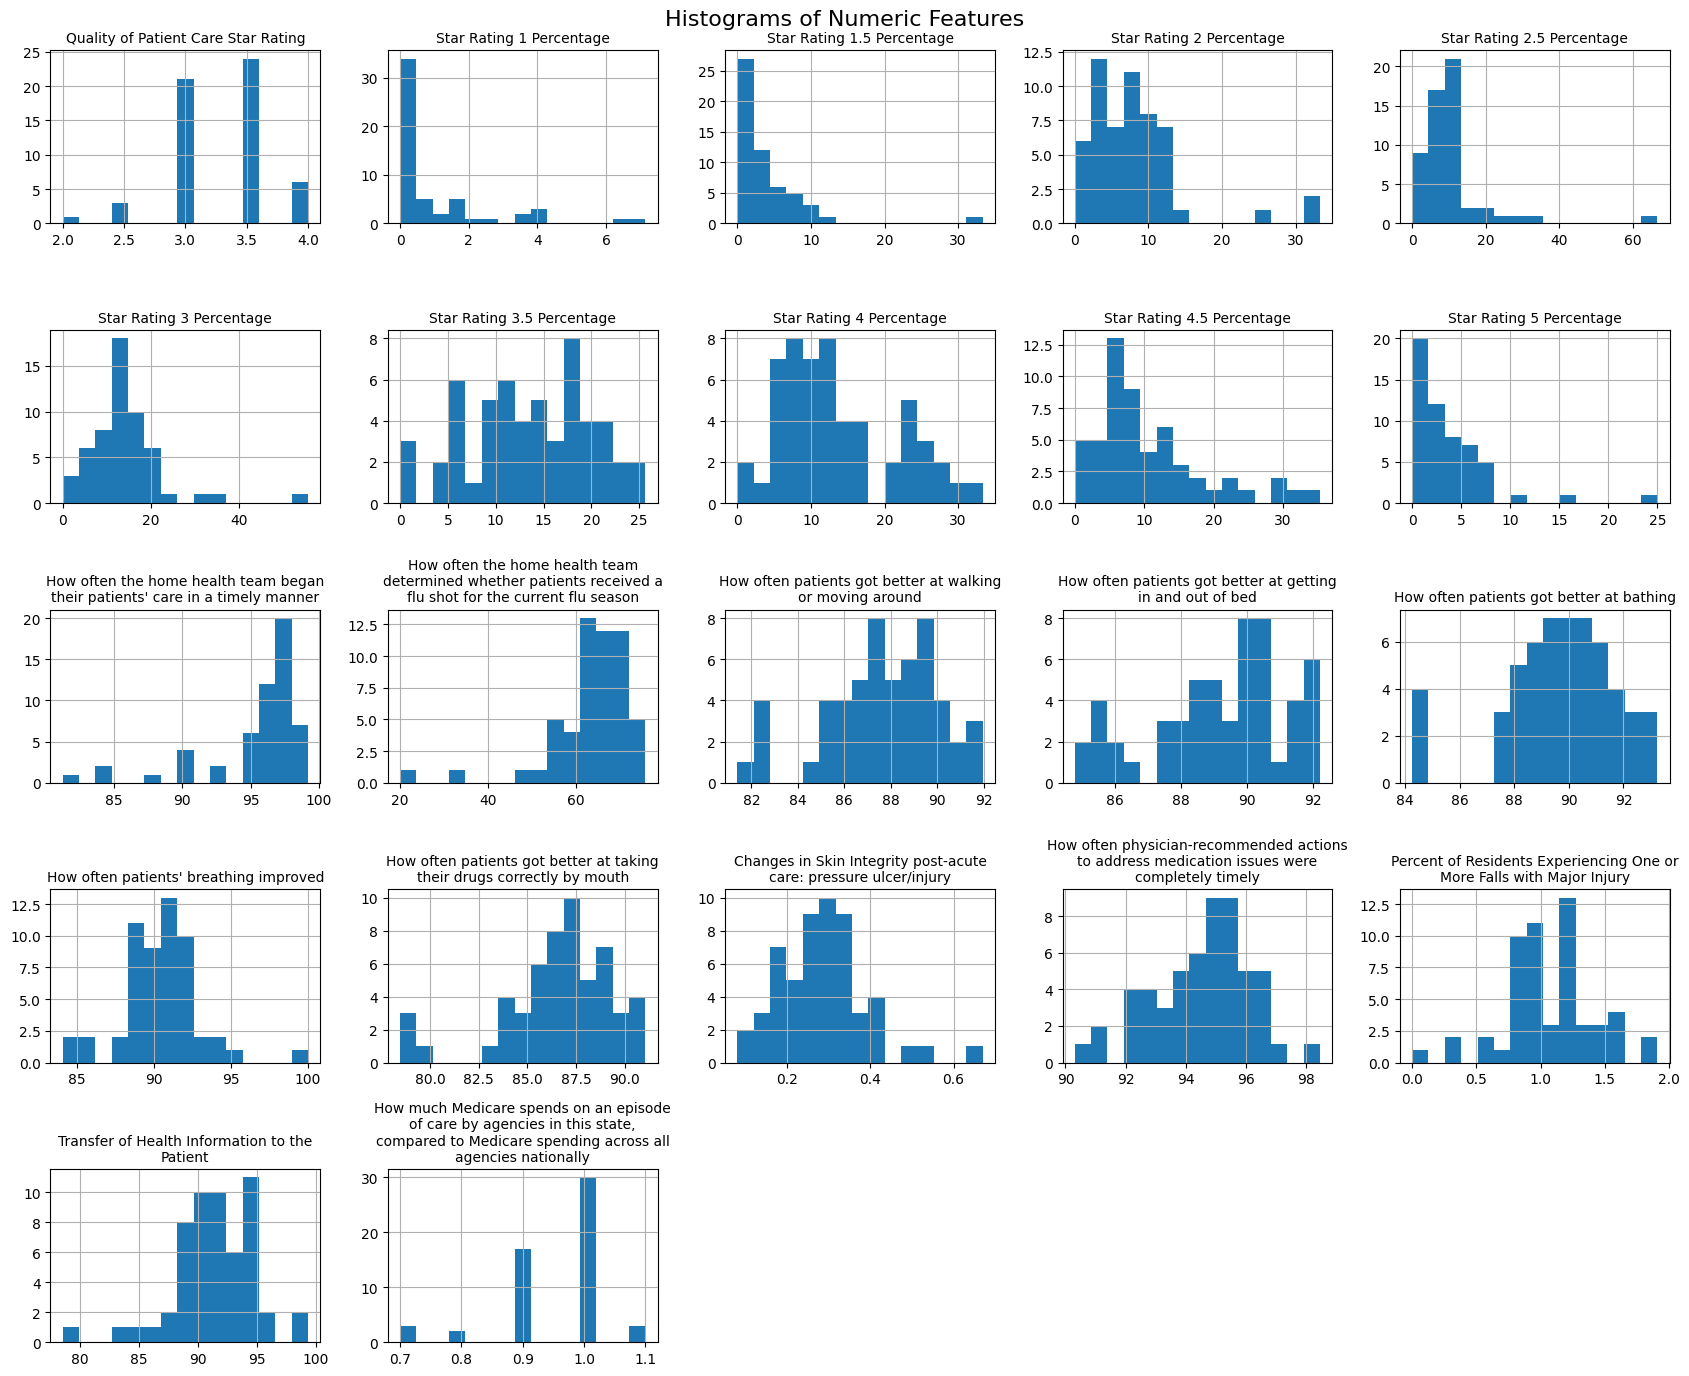


--- Training Model (Target: Quality of Patient Care Star Rating) ---
Model trained — MSE: 0.1274, R²: 0.5597

Top 10 Features Influencing Star Rating:
                                             Feature  Importance
2  How often patients got better at walking or mo...    0.369602
3  How often patients got better at getting in an...    0.232585
4           How often patients got better at bathing    0.122870
0  How often the home health team began their pat...    0.071865
6  How often patients got better at taking their ...    0.055720
5             How often patients' breathing improved    0.032755
7  Changes in Skin Integrity post-acute care: pre...    0.030392
9  Percent of Residents Experiencing One or More ...    0.023277
8  How often physician-recommended actions to add...    0.022401
1  How often the home health team determined whet...    0.021530


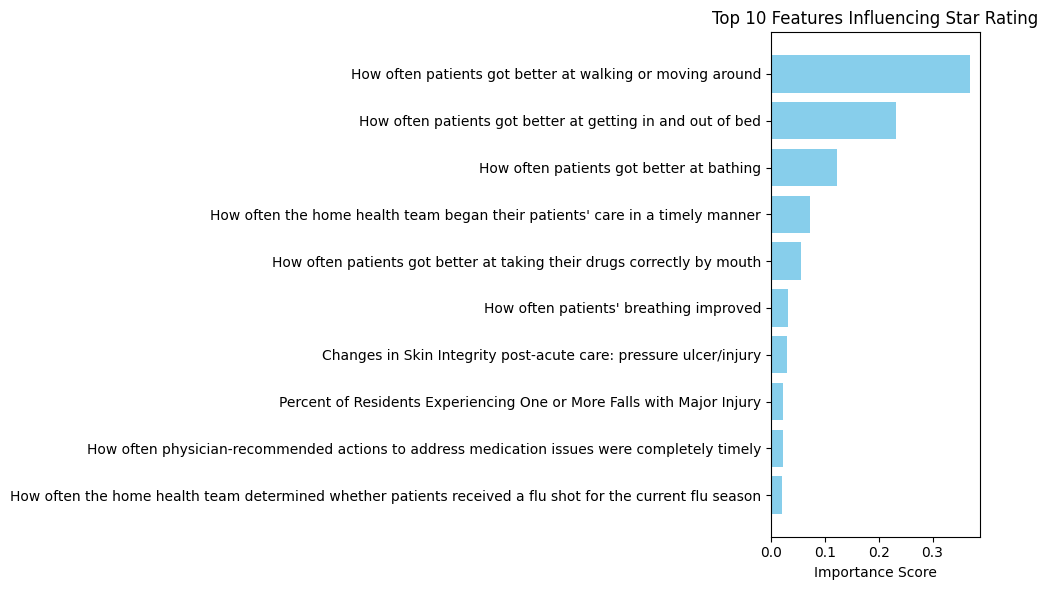


What-if: +10% 'How often the home health team determined whether patients received a flu shot for the current flu season' → Avg predicted rating change: +0.00


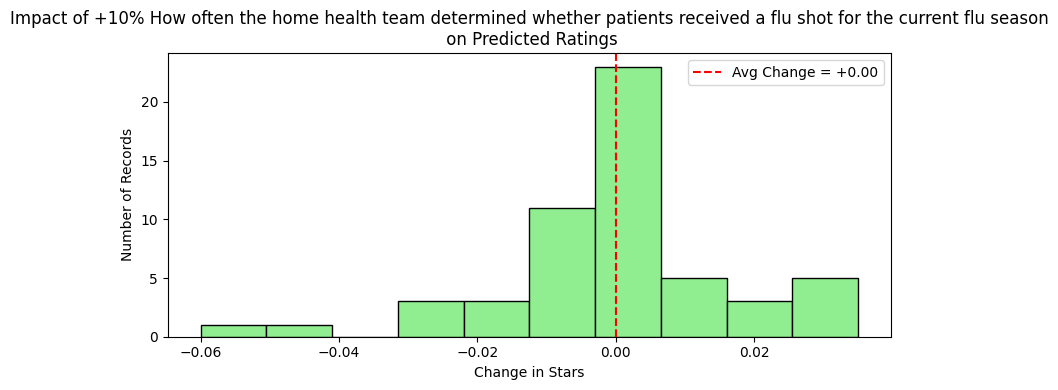


Top 5 Records with Biggest Improvement:
State  Change
   OH   0.035
   MP   0.030
   MA   0.030
   HI   0.030
   GU   0.030


In [23]:

# Usage

if __name__ == "__main__":
    run_analysis(
        filepath="HH_State_Oct2025.csv",
        target_col="Quality of Patient Care Star Rating",
        flu_col="How often the home health team determined whether patients received a flu shot for the current flu season"
    )


## 6. Deployment

The main findings from the analysis are summarized in the Medium post available [here](https://medium.com/@hirzahida/improving-home-health-care-quality-a-data-driven-approach-a4e345dc19f7?postPublishedType=repub).